In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [2]:
p = [0.5, 0.3, 0.6, 0.4, 0.2] # p[i] = probability of earning 1 if the arm i is chosen

def reward(arm):
    return 1 if (np.random.rand() <= p[arm]) else 0

nbArms = 5

def UCB(T):
    rewards = np.zeros(nbArms)
    nbPlayed = np.zeros(nbArms)

    rewardsTimeSeries = np.zeros((T,nbArms))
    errorRewarsTimeSeries = np.zeros((T,nbArms))
    actionsTimeSeries = np.zeros((T))

    
    for t in range(T):
        averageReward = [x if x>0 else 0 for x in rewards / nbPlayed]
        c = np.sqrt( 2* np.log(t+1) / (nbPlayed+1) )
        action = np.argmax(averageReward+c)
        #if averageReward[0]+c[0]> averageReward[1]+c[1]:
        #    action = 0
        #else:
        #    action = 1
        rewards[action] += reward(action)
        nbPlayed[action] += 1
        
        rewardsTimeSeries[t,:] = averageReward
        errorRewarsTimeSeries[t,:] = c
        actionsTimeSeries[t] = action
        #print(c)
    
    return(rewardsTimeSeries,errorRewarsTimeSeries,actionsTimeSeries)

In [3]:
np.random.seed(42) # for reproducibility
T=1000
R,E,A = UCB(T)
[print('Arm {0} was chosen {1} times'.format(i,sum(A==i))) for i in range(nbArms)]
x,y,e=1+np.arange(nbArms),R[10],E[10]


Arm 0 was chosen 138 times
Arm 1 was chosen 81 times
Arm 2 was chosen 637 times
Arm 3 was chosen 84 times
Arm 4 was chosen 60 times


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


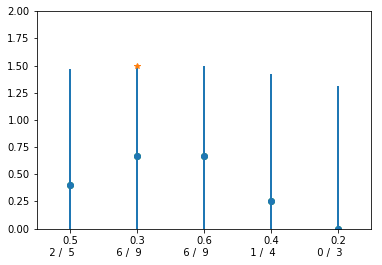

In [4]:
def plot_ucb(num,x,Y,E, line):
    plt.clf()
    plt.xlim(0.5, 5.5)
    plt.ylim(0, 2)
    plt.errorbar(x,Y[num],E[num],fmt='o',lw=2, capthick=2, animated=True)
    n = np.argmax(Y[num]+E[num])
    plt.plot([n+1],[Y[num,n]+E[num,n]],'*')
    plt.plot(x,Y[num],'o')
    plt.xticks(x,['{}'.format(p[i]) for i in range(nbArms)])
    for i in range(nbArms):
        plt.text(i+.6,-.25,'{:3d} /{:3d}'.format(int(Y[num,i]*(sum(A[:num]==i))),sum(A[:num]==i)))
    if line is not None: line.set_data(x,Y[num])
    return line,

fig = plt.figure()
plot_ucb(30,x,R,np.array(E),None)
fig.savefig('ucb_image.pdf',bbox_inches='tight')
#plt.savefig('ucb_plot')

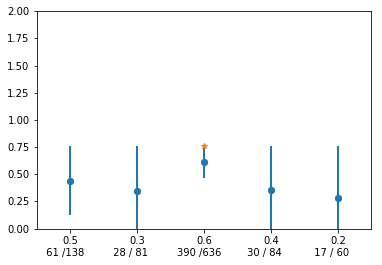

In [5]:
fig1 = plt.figure()

x=[1,2,3,4,5]

l, = plt.plot([], [], '+')

ucb_ani = animation.FuncAnimation(fig1, plot_ucb, 1000, fargs=(x,R,E,l),
                                   interval=100, blit=True)
ucb_ani.save('ucb.mp4')


# Thompson

In [6]:
def thompson(T):
    rewards = np.zeros(nbArms)
    nbPlayed = np.zeros(nbArms)

    rewardsTimeSeries = np.zeros((T,nbArms))
    actionsTimeSeries = np.zeros((T))
    played = np.zeros((T,nbArms))
    gained = np.zeros((T,nbArms))
    
    for t in range(T):
        arms = [np.random.beta(1+rewards[i],1+nbPlayed[i]) for i in range(nbArms)]
        action = np.argmax(arms)
        rewards[action] += reward(action)
        nbPlayed[action] += 1
        
        rewardsTimeSeries[t,:] = rewards/nbPlayed
        actionsTimeSeries[t] = action
        played[t,:] = nbPlayed
        gained[t,:] = rewards
    return(rewardsTimeSeries,actionsTimeSeries,np.array(played),np.array(gained))

In [7]:
np.random.seed(42) # for reproducibility
_,_,P,G=thompson(1000)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


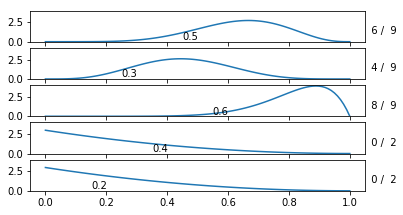

In [8]:
from scipy.stats import beta 
x = np.linspace(0,1,100)
def plot_thompson(t,y,line=None):
    plt.clf()
    for i in range(nbArms):
        plt.subplot(nbArms+1,1,i+1)
        rv = beta(G[t,i]+1,P[t,i]-G[t,i]+1)
        y = rv.pdf(x)
        plt.plot(x,y)
        plt.ylim(0, max(4,int(np.max(y))+1))
        plt.text(1.05,1,'{:3d} /{:3d}'.format(int(G[t,i]),int(P[t,i])))
        plt.text(p[i]-.05,.2,'{}'.format(p[i]))
    return line,
fig = plt.figure()
plot_thompson(30,None)
fig.savefig('thompson_image.pdf',bbox_inches='tight')

## Warning: execution of the next code takes time

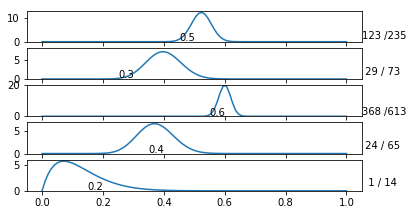

In [9]:
# This takes forever to execute!

fig1 = plt.figure()

for i in range(nbArms):
    plt.subplot(nbArms+1,1,i+1)
    l, = plt.plot([], [], '+')

thompson_ani = animation.FuncAnimation(fig1, plot_thompson, 1000, fargs=(x,l),
                                   interval=100, blit=True)
thompson_ani.save('thompson.mp4')
#plot_error_bar([1,2,3],[.5,.7,.6],[.1,.2,.1])

# Regret comparisons

In [10]:
def epsilonGreedy(T,epsilon):
    rewards = np.zeros(nbArms)
    nbPlayed = np.zeros(nbArms)
    
    rewardsTimeSeries = np.zeros((T,nbArms))
    actionsTimeSeries = np.zeros((T))
    
    for t in range(T):
        if np.random.rand() <= epsilon or nbPlayed[0] == 0 or nbPlayed[1]==0:
            action = np.random.randint(2)
        else:
            if rewards[0]/nbPlayed[0] >= rewards[1]/nbPlayed[1]:
                action = 0
            else:
                action = 1
        rewards[action] += reward(action)
        nbPlayed[action] += 1
        
        rewardsTimeSeries[t,:] = rewards/nbPlayed
        actionsTimeSeries[t] = action

    return(rewardsTimeSeries,actionsTimeSeries)
#epsilonGreedy(100,0.)

In [11]:
def epsilonGreedy(T,epsilon):
    rewards = np.zeros(nbArms)
    nbPlayed = np.zeros(nbArms)
    
    rewardsTimeSeries = np.zeros((T,nbArms))
    actionsTimeSeries = np.zeros((T))
    
    for t in range(T):
        if np.random.rand() <= epsilon or any(nbPlayed==np.zeros(nbArms)):
            action = np.random.randint(nbArms)
        else:
            action = np.argmax(rewards/nbPlayed)
        rewards[action] += reward(action)
        nbPlayed[action] += 1
        
        rewardsTimeSeries[t,:] = rewards/nbPlayed
        actionsTimeSeries[t] = action

    return(rewardsTimeSeries,actionsTimeSeries)
#epsilonGreedy(100,0.1)

In [12]:
np.random.seed(42) # for reproducibility
def averageReward(policy,T,nbSamples):
    averageReward = np.zeros(T)
    bestArm = max(p)
    for i in range(nbSamples):
        actionSequence = policy(T)[-1]
        averageReward += np.array([p[int(actionSequence[i])] for i in range(T)])/nbSamples
    return( averageReward )
reg_01greedy=averageReward(lambda T: epsilonGreedy(T,0.1),1000,1000)
reg_001greedy=averageReward(lambda T: epsilonGreedy(T,0.01),1000,1000)
reg_05greedy=averageReward(lambda T: epsilonGreedy(T,0.5),1000,1000)
reg_0greedy=averageReward(lambda T: epsilonGreedy(T,0.),1000,1000)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


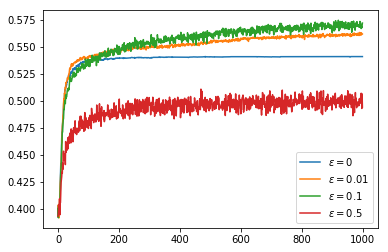

In [13]:
f = plt.figure()
plt.plot(reg_0greedy)
plt.plot(reg_001greedy)
plt.plot(reg_01greedy)
plt.plot(reg_05greedy)
plt.legend(['$\epsilon=0$','$\epsilon=0.01$','$\epsilon=0.1$','$\epsilon=0.5$'])
f.savefig('epsilon_greedy.pdf',bbox_inches='tight')

In [14]:
np.random.seed(42) # for reproducibility

def averageRegret(policy,T,nbSamples):
    averageReward = np.zeros(T)
    bestArm = max(p)
    for i in range(nbSamples):
        if policy==UCB:
            actionSequence = policy(T)[2]
        else:
            actionSequence = policy(T)[1]
        averageReward += np.array([p[int(actionSequence[i])] for i in range(T)])/nbSamples
    return( np.cumsum(bestArm - averageReward) )

UCB_reg = averageRegret(UCB,10000,50)
TS_reg = averageRegret(thompson,10000,50)
Eps01_reg = averageRegret(lambda x:epsilonGreedy(x,.01),10000,100)
Eps1_reg = averageRegret(lambda x:epsilonGreedy(x,.1),10000,100)
Eps05_reg = averageRegret(lambda x:epsilonGreedy(x,.05),10000,100)
#Eps1_reg = averageRegret(lambda x:epsilonGreedy(x,.1),10000,100)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


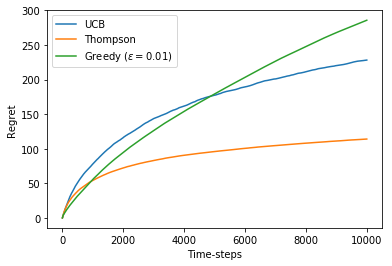

In [15]:
fig = plt.figure() 
plt.plot(UCB_reg)
plt.plot(TS_reg)
plt.plot(Eps01_reg)
plt.legend(('UCB',"Thompson",'Greedy ($\epsilon=0.01$)'))
plt.xlabel('Time-steps')
plt.ylabel('Regret')

fig.savefig('regret_comparison_UCB_TS_epsilonGreedy.pdf',bbox_inches='tight')

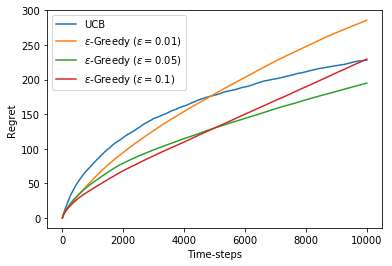

In [16]:
fig = plt.figure() 
plt.plot(UCB_reg)
plt.plot(Eps01_reg)
plt.plot(Eps05_reg)
plt.plot(Eps1_reg)
plt.legend(('UCB','$\epsilon$-Greedy ($\epsilon=0.01$)',
            '$\epsilon$-Greedy ($\epsilon=0.05$)',
            '$\epsilon$-Greedy ($\epsilon=0.1$)'))
plt.xlabel('Time-steps')
plt.ylabel('Regret')

fig.savefig('regret_comparison_UCB_epsilonGreedy.pdf',bbox_inches='tight')

# EXP.3

We apply Exp3 for stochastic bandits

In [75]:
def Exp3(T):
    rewards = np.zeros(nbArms)
    
    rewardsTimeSeries = np.zeros((T,nbArms))
    actionsTimeSeries = np.zeros((T))
    
    for t in range(T):
        tau = 1/np.sqrt(nbArms*T+1)
        p = np.exp(tau*(rewards-max(rewards)))
        p = p/sum(p)
        #print(p)
        action=np.random.choice(nbArms,p=p)
        rewards[action] += reward(action)/p[action]
        
        rewardsTimeSeries[t,:] = rewards
        actionsTimeSeries[t] = action

    return(rewardsTimeSeries,actionsTimeSeries)
Exp3(10000)
#epsilonGreedy(100,0.1)

(array([[5.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [5.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [5.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        ...,
        [5.25215718e+03, 1.28928940e+03, 6.08608663e+03, 3.41339917e+03,
         7.71335658e+02],
        [5.25215718e+03, 1.28928940e+03, 6.08711065e+03, 3.41339917e+03,
         7.71335658e+02],
        [5.25215718e+03, 1.28928940e+03, 6.08813455e+03, 3.41339917e+03,
         7.71335658e+02]]), array([0., 3., 1., ..., 2., 2., 2.]))

In [76]:
np.random.seed(42)
exp3_T = averageRegret(lambda x:Exp3(x),10000,100)

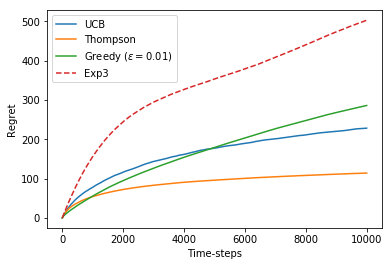

In [77]:
fig = plt.figure()
plt.plot(UCB_reg)
plt.plot(TS_reg)
plt.plot(Eps01_reg)
plt.plot(exp3_T,'--')
plt.legend(('UCB',"Thompson",'Greedy ($\epsilon=0.01$)','Exp3'))
plt.xlabel('Time-steps')
plt.ylabel('Regret')

fig.savefig('regret_comparison_UCB_TS_epsilonGreedy_exp3.pdf',bbox_inches='tight')
